## **Классификация звонковых транзакций с использованием DecisionTreeClassifier**

---



**Обработка данных**

In [80]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import graphviz 
from sklearn.ensemble import VotingClassifier


In [21]:
samples = pd.read_csv('./data/beeline_antispam_hakaton_id_samples.csv')
print(samples.head())

         id  target  split
0    196535     NaN   test
1  63075900     2.0  train
2  35233935     2.0  train
3  23557360     4.0  train
4  78926486     NaN   test


In [22]:
print(samples.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46235 entries, 0 to 46234
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      46235 non-null  int64  
 1   target  36942 non-null  float64
 2   split   46235 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB
None


In [23]:
data = pd.read_csv('./data/time_key=2021-11-01.csv')
print(data.head())
                     


       id_a      id_b start_time_local  time_zone  duration  forward  \
0  67596082  43588153         18:43:03          3         0        0   
1   4024969  67656553         11:43:20          4       206        0   
2  43166780  31861625         10:32:36          0         5        0   
3  51817902  41201237         13:45:02          3         0        0   
4  41812796   4932754         13:53:12          0         0        0   

   zero_call_flg  source_b  source_f  num_b_length    time_key  
0            3.0       0.0       1.0          10.0  2021-11-01  
1            5.0       1.0       0.0          10.0  2021-11-01  
2            0.0       0.0       1.0          10.0  2021-11-01  
3            0.0       0.0       1.0          10.0  2021-11-01  
4            5.0       0.0       1.0          10.0  2021-11-01  


In [24]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2902169 entries, 0 to 2902168
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id_a              int64  
 1   id_b              int64  
 2   start_time_local  object 
 3   time_zone         int64  
 4   duration          int64  
 5   forward           int64  
 6   zero_call_flg     float64
 7   source_b          float64
 8   source_f          float64
 9   num_b_length      float64
 10  time_key          object 
dtypes: float64(4), int64(5), object(2)
memory usage: 243.6+ MB
None


Выделим фичи из датасета и поделим их на числовые и категориальные.

In [152]:
num_cols = [
    'start_time_local',
    'duration',
    'num_b_length',
    'time_key'
]

cat_cols = [
    'id_a', 
    'id_b',
    'time_zone',
    'forward',
    'zero_call_flg',
    'source_b',
    'source_f',
]

cat_cols_without_ids = [
    'time_zone',
    'forward',
    'zero_call_flg',
    'source_b',
    'source_f',
]


cols = num_cols + cat_cols_without_ids
cols_withot_ids = num_cols + cat_cols
data = data[cols]



Посмотрим на пропущенные значения и уберем их при необходимости

In [26]:
data = data.dropna()

## **Preprocessing**
---

**Преобразуем время к числу**

In [27]:
# Время указано в секундах
data['start_time_local'] = pd.to_timedelta(data['start_time_local']).dt.total_seconds()
print(data['start_time_local'].head())

0    67383.0
1    42200.0
2    37956.0
3    49502.0
4    49992.0
Name: start_time_local, dtype: float64


**Выделение нового признака из даты**

In [28]:
print(data['time_key'].head())
# Извлечем определенный день в месяце
data['time_key'] = pd.to_datetime(data['time_key'], errors='coerce').dt.day
print(data['time_key'].head())

0    2021-11-01
1    2021-11-01
2    2021-11-01
3    2021-11-01
4    2021-11-01
Name: time_key, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: time_key, dtype: int64


**Разделим данные на выборку для обучения и выборку для тестирования**

In [29]:
data = (
        data
        .merge(samples[['id','target', 'split']], left_on='id_a', right_on='id', how='inner') 
        .drop(columns=['id'])
)

data , data_predict = [x for _, x in data.groupby(data['split'] == 'test')]
data = data.drop('split', axis=1)
data_predict = data_predict.drop('split', axis=1)
print(data.info())
print()
print(data_predict.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039211 entries, 0 to 2902167
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   start_time_local  float64
 1   duration          int64  
 2   num_b_length      float64
 3   time_key          int64  
 4   id_a              int64  
 5   id_b              int64  
 6   time_zone         int64  
 7   forward           int64  
 8   zero_call_flg     float64
 9   source_b          float64
 10  source_f          float64
 11  target            float64
dtypes: float64(6), int64(6)
memory usage: 202.3 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862957 entries, 4523 to 2902158
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   start_time_local  862957 non-null  float64
 1   duration          862957 non-null  int64  
 2   num_b_length      862957 non-null  float64
 3   time_key          862957 non-null  

**Посмотрим на распределение целевой переменной**

In [30]:
print(data['target'].value_counts())

4.0    1739980
2.0     101363
3.0      96290
0.0      87671
1.0      13907
Name: target, dtype: int64


<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
    <font size="4", color="DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br><br>
    <font size="3", color="black">
        Исторически уже так сложилось, что матрица с признаками обозначается за X (заглавной), т.к. это матрица, а y (прописной), т.к. в базовых задачах - вектор. Кароче, X и y - устоявшиеся обозначения!
    </font>
    <br><br>
    <font size="3", color="black">
        Везде, где есть влияние случайности стоит фиксировать random_state.
    </font>
<div>

In [31]:
# TODO: ещё здесь ты учишь модель на id. на одном дне это ещё может и сработать, но что делать с новыми абонентами?
y = data['target']
X = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
)

In [153]:
# Создание объекта дерева решений
clf = DecisionTreeClassifier()
clf = clf.fit(X_train[cols_withot_ids], y_train)
# Предсказание ответа для тестового набора данных
y_pred = clf.predict(X_test)


Посмотрим на параметры, которые использовались в модели:

In [154]:
print('Глубина: ', clf.get_depth())
print('Критерий разбивки: ', clf.criterion) 
print('Количество листьев в дереве: ', clf.get_n_leaves())

Глубина:  40
Критерий разбивки:  gini
Количество листьев в дереве:  20961


**Оценка точности**

In [39]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9877550920329636


**Найдем наилучшие параметры при помощи кросс-валидации**

In [155]:
parameters={
        'max_depth': range(3, 5),
        'min_samples_split': range(2, 4),
        'criterion': ['gini', 'entropy']
    }
clfBest = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    n_jobs=-1,  # ознначает, что будут использоваться все процессоры для параллельных вычислений
    verbose=3,
    refit = True,
)
clfBest.fit(X_train[cols_withot_ids], y_train)
None  

Fitting 5 folds for each of 8 candidates, totalling 40 fits


DecisionTreeClassifier(max_depth=4)
0.8849830328100646
{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}


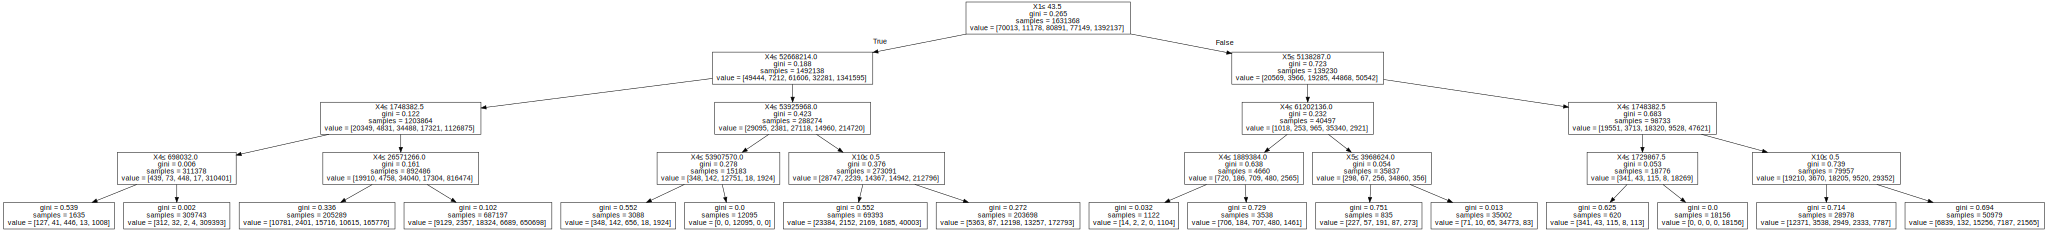

In [156]:

# Оценщик выбранный при поиске, то есть оценщик, который имеет максимальный счет на пропущенных данных
print(clfBest.best_estimator_)

# Среднее значение счета кросс-валидации для best_estimator 
print (clfBest.best_score_)

# Лучшие значения параметров
print(clfBest.best_params_)
dot_data = tree.export_graphviz(clfBest.best_estimator_, out_file=None,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

**Обучим модель с наилучшими параметрами и сравним её с прошлым вариантом модели**

In [ ]:
y_predBest = clfBest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_predBest))

**Перейдем от классификации транзакций к классификации абонентов**

In [ ]:
# # Доказательство, что документация sklearn (https://pandas.pydata.org/docs/dev/reference/api/pandas.core.groupby.DataFrameGroupBy.value_counts.html) врет:
# df = pd.DataFrame({
#    'gender': ['male', 'male', 'female', 'male', 'female', 'male'],
#    'education': ['low', 'medium', 'high', 'low', 'high', 'low'],
#    'country': ['US', 'FR', 'US', 'FR', 'FR', 'FR']
# })
# print(df)

# df.groupby('gender').value_counts()


In [148]:
print(data['id_a'].value_counts())
dataIds = [x for _, x in data.groupby(data['id_a'])]
mapId = data['id_a'].to_dict()
for i in dataIds:
  estimates = i['target'].value_counts()
  maxEstimate = estimates.idxmax()
  i['target'] = maxEstimate





Выходные данные были обрезаны до нескольких последних строк (5000).






































































































































































































































































































































































































































































































































































































































































































































































































































































































































































<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
    <font size="4", color="DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br><br>
    <font size="3", color="black">
        Сейчас ты классифицируешь транзакции, а задача - классифицировать абонентов. Получается, что для одного абонента может быть несколько транзакций с разными предсказанными классами. Далее нужно на основе предсказаний транзакций сделать предсказание для абонента. Это можно сделать 2 способами: 1) жёсткое голосование (обычное), 2) мягкое голосование, то есть усредняются вероятности классов по всем транзакциям и выбирается класс с наибольшей вероятностью.
    </font>
<div>